In [28]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [29]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

In [151]:
# image_name = "tire_interpolation-5.png"
# image_extension = image_name.split(".")[-1]
# image_name = image_name.split(".")[0]

image_name = "hole_tire.jpg"
image_extension = image_name.split(".")[-1]
image_name = image_name.split(".")[0]

image = cv2.imread("./in/"+image_name+"."+image_extension)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

b, g, r = cv2.split(image)

channels = [b, g, r, cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)]
channel_names = ["blue", "green", "red", "gray"]

Try automatic Canny tresholding method

In [38]:
for i, c in enumerate(channels):
    temp = c
    temp = cv2.GaussianBlur(temp, (3, 3), 0)
    res = auto_canny(temp)

    cv2.imwrite("./out/canny_on_original/"+image_name+"_" + channel_names[i] + "_canny-auto."+image_extension, res)

Histogram of the input channels

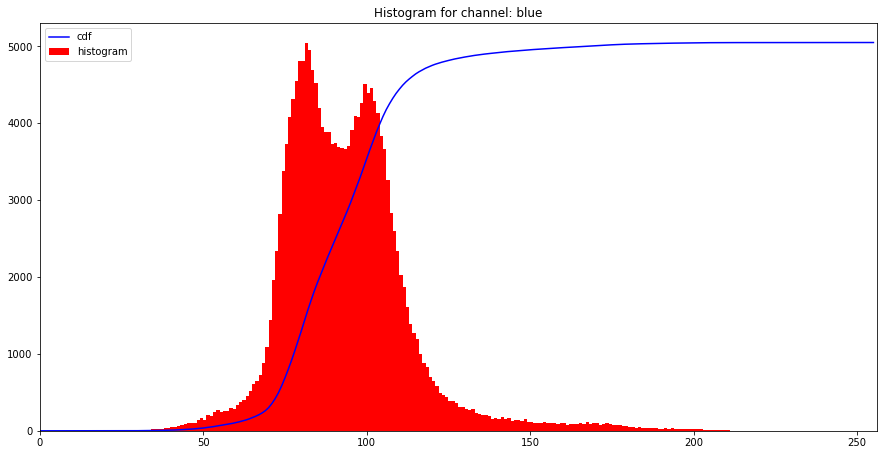

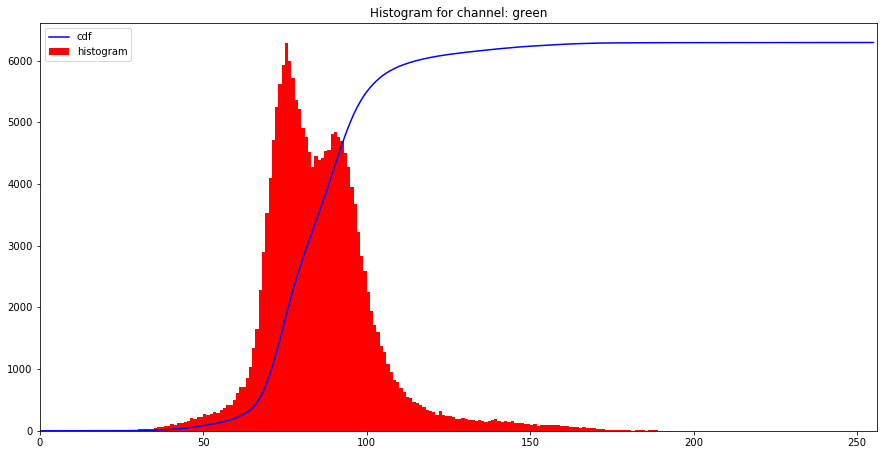

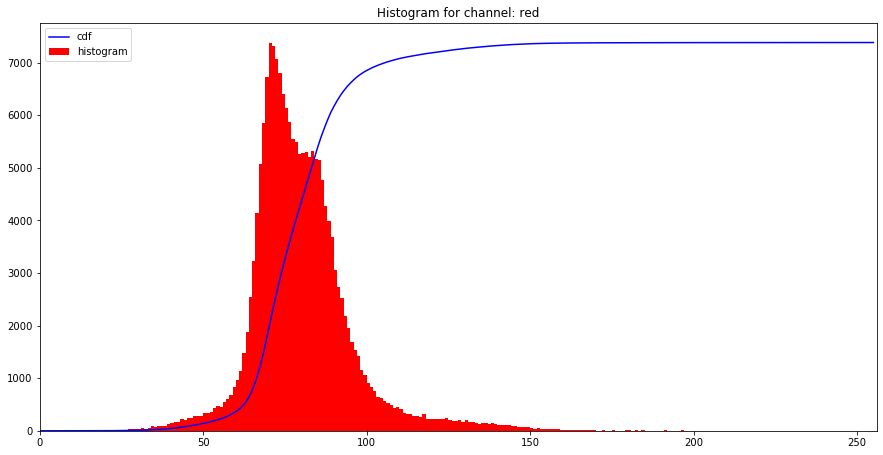

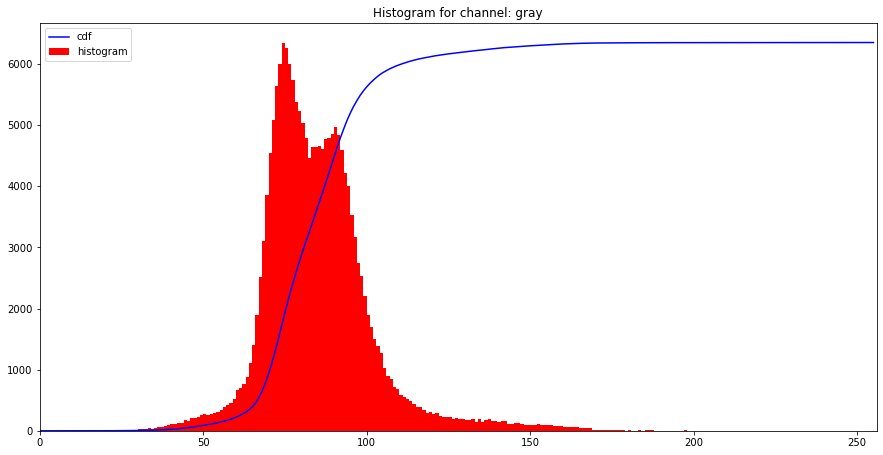

In [35]:
for i, c in enumerate(channels):
    hist,bins = np.histogram(c.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(c.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title('Histogram for channel: ' + channel_names[i])
    plt.show()


Apply normal uniform Equalization of the Histogram

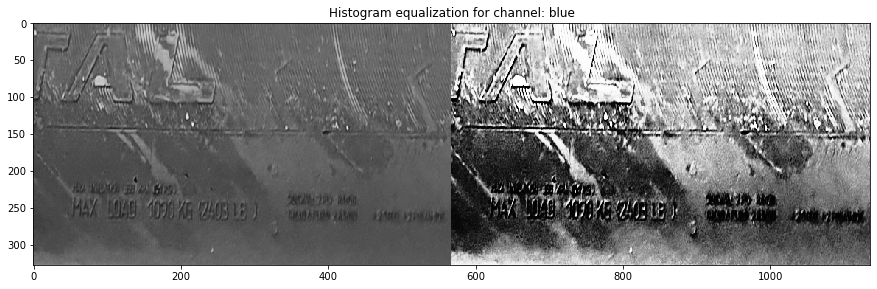

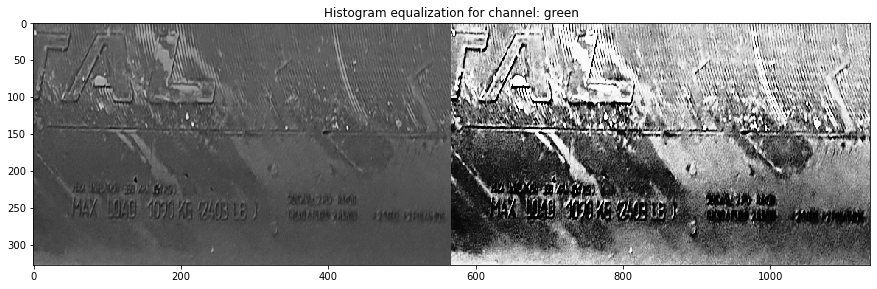

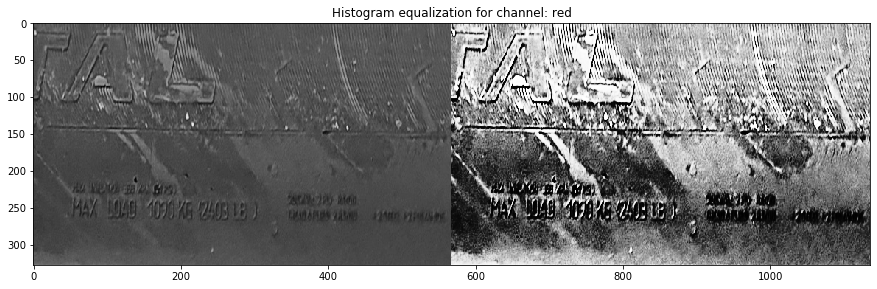

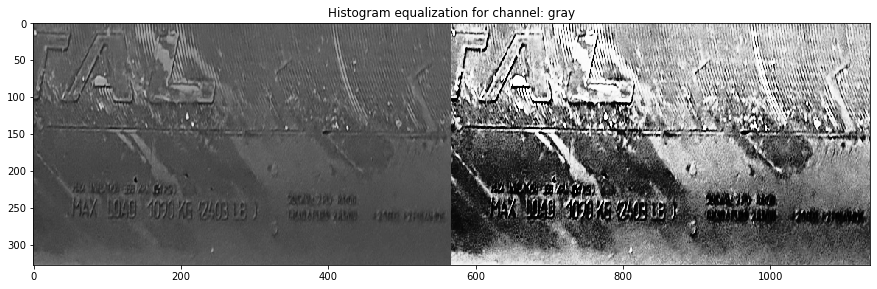

In [51]:
for i, c in enumerate(channels):
    equ = cv2.equalizeHist(c)
    res = np.hstack((c,equ)) #stacking images side-by-side

    # increase plot size
    plt.rcParams["figure.figsize"] = (15,7.5)
    plt.imshow(res, cmap='gray')
    plt.title('Histogram equalization for channel: ' + channel_names[i])
    plt.show()

Apply CLAHE

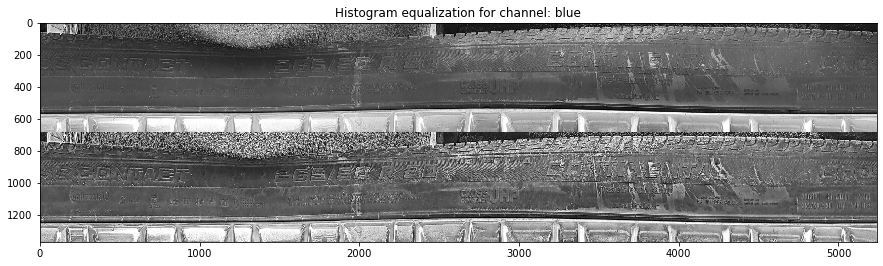

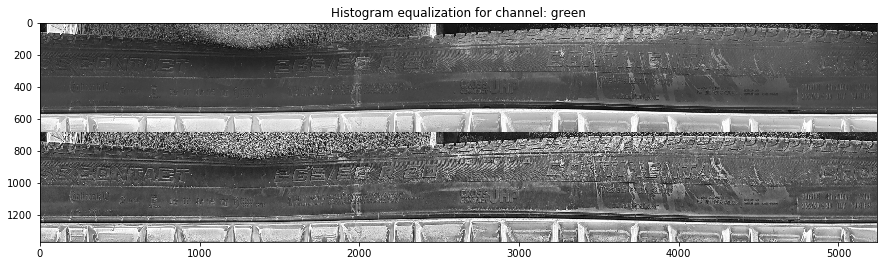

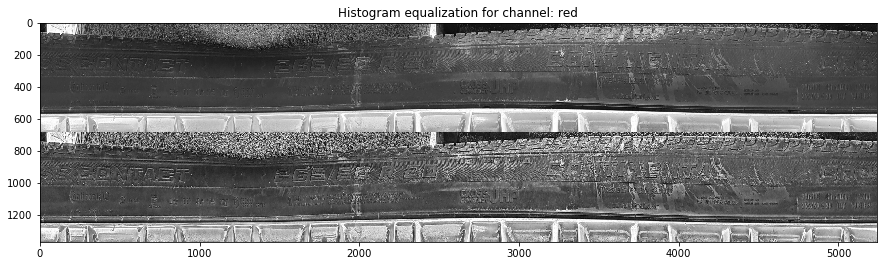

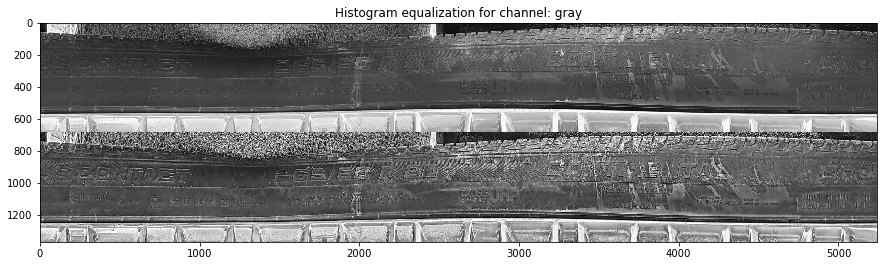

In [152]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(200,20))

chan_c = []

for i, c in enumerate(channels):
    temp = c
    temp = cv2.GaussianBlur(temp, (3, 3), 0)
    res = clahe.apply(temp)
    chan_c.append(res)
    res = np.vstack((temp, res)) #stacking images side-by-side

    plt.rcParams["figure.figsize"] = (15,7.5)
    plt.imshow(res, cmap='gray')
    plt.title('Histogram equalization for channel: ' + channel_names[i])
    plt.show()

    cv2.imwrite("./out/clahe_on_original/"+image_name+"_" + channel_names[i] + "."+image_extension, res)

See the histogram for the CLAHE's output

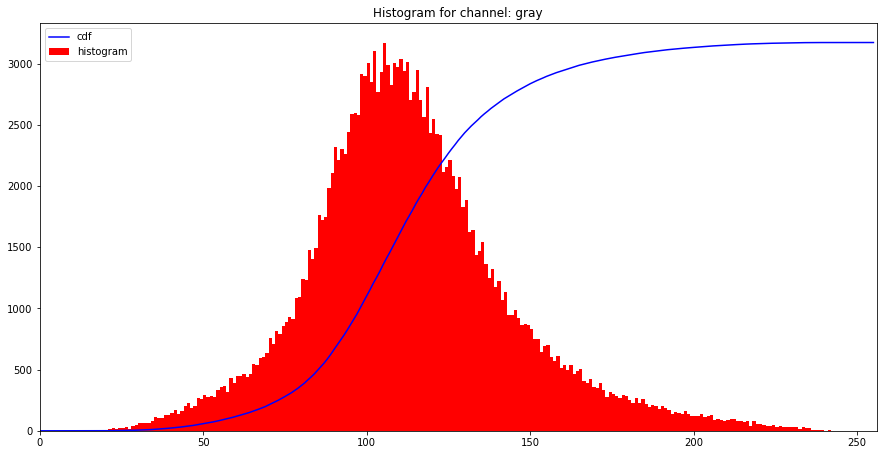

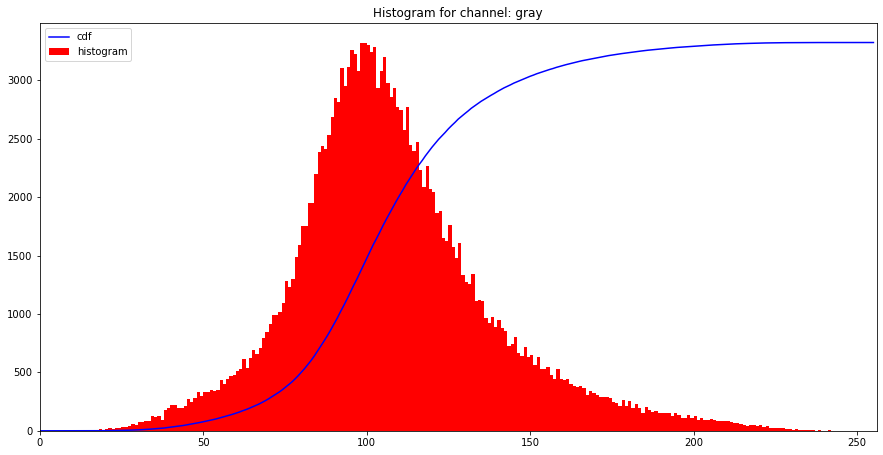

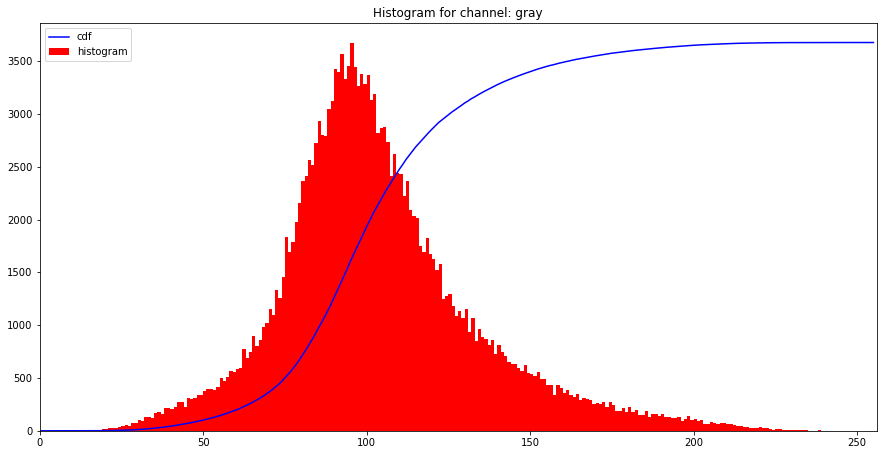

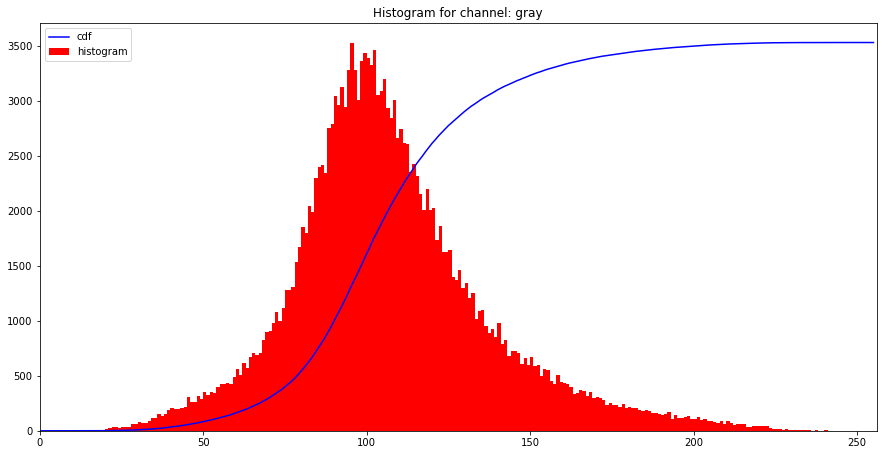

In [41]:
for _, c in enumerate(chan_c):
    hist,bins = np.histogram(c.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    plt.plot(cdf_normalized, color = 'b')
    plt.hist(c.flatten(),256,[0,256], color = 'r')
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title('Histogram for channel: ' + channel_names[i])
    plt.show()

Try some Canny and Sobel directly on CLAHE's output

In [53]:
red_c = chan_c[2] #let's use red channel

# apply canny edge detector
red_c_blur = cv2.GaussianBlur(red_c, (3, 3), 0)
red_c_auto = auto_canny(red_c, sigma=0.33)

gx = cv2.Sobel(red_c_blur, cv2.CV_64F, 1, 0)
gy = cv2.Sobel(red_c_blur, cv2.CV_64F, 0, 1)

g = cv2.addWeighted(gx, 0.5, gy, 0.5, 0)

cv2.imwrite("./out/"+image_name+"_red_canny-auto."+image_extension, red_c_auto)
cv2.imwrite("./out/"+image_name+"_red_Sobel."+image_extension, g)

True

Canny on CLAHE processed channels

In [60]:
for i, c in enumerate(chan_c):
    # res_canny_auto = auto_canny(c, sigma=0.33)
    # cv2.imwrite("./out/tire_interpolation-5_CLAHE_canny-auto_" + channel_names[i] + ".png", res_canny_auto)
    temp = c
    temp = cv2.GaussianBlur(temp, (3, 3), 0)
    res_auto_canny = auto_canny(temp, sigma=0.33)
    cv2.imwrite("./out/"+image_name+"_CLAHE_canny-auto_" + channel_names[i] + "."+image_extension, res_auto_canny)
    res_canny = cv2.Canny(temp, 120, 160)
    cv2.imwrite("./out/"+image_name+"_CLAHE_canny_" + channel_names[i] + "."+image_extension, res_canny)

Try some Otsu Thresholding on the original channel and on the CLAHE's output

**Observations**:

- Not good for text in hole images. But Otsu on the original image may be useful for removing the silver wheel's rim on the bottom of the immage if needed.

- On a smaller section that consists only of the tire, Otsu on the CLAHE image can show some letters and conturs, while on the original immage writting looks like noise because we didn't apply a blur.

In [ ]:
print("On Original:")
for i, c in enumerate(channels):
    temp = c
    # temp = cv2.GaussianBlur(temp, (3, 3), 0)
    (T, res) = cv2.threshold(temp, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    print("\t", channel_names[i], "threshold value is:", T)
    cv2.imwrite("out/otsu_tresh_on_original/"+image_name+"_" + channel_names[i] +"_otsu."+image_extension, res)


print("On CLAHE:")
for i, c in enumerate(chan_c):
    temp = c
    (T, res) = cv2.threshold(temp, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    print("\t", channel_names[i], "threshold value is:", T)
    cv2.imwrite("out/otsu_tresh_on_clahe/"+image_name+"_" + channel_names[i] +"_otsu."+image_extension, res)

The last hope I think, Adaptive Thresholding

In [183]:
for i, c in enumerate(channels):
    temp = c
    temp = cv2.medianBlur(temp, 5)
    res = cv2.adaptiveThreshold(temp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 2)
    cv2.imwrite("./out/adapt-thold_on_original/"+image_name+"_" + channel_names[i] + "."+image_extension, res)

for i, c in enumerate(chan_c):
    temp = c
    temp = cv2.medianBlur(temp, 5)
    res = cv2.adaptiveThreshold(temp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    cv2.imwrite("./out/adapt-thold_on_clahe/"+image_name+"_" + channel_names[i] + "."+image_extension, res)